# Creating clustered polygons from GAEZ ascii grid

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />

#### This notebook creates vector polygons covering a clusterized area of interest

We focus on three types of clusters:

- Based on admin level 1
- Based on admin level 2
- Based on CLEWs clusters (read more about that [here](https://clews-gis.readthedocs.io/en/latest/)

The latter is the reason we use GAEZ ascii grid as an input; that is, to be able to provide a spatial index to the CLEWs derived clusters, which are defined based on the row, col of that grid. 

The polygons provide higher flexibility in extracting numerical and (especially) categorical raster layer stats, which might come at various spatial resolutions.  

In brief, the process has as follows:

- First (**Step 1**), we import a sample ascii grid file using rasterio and convert it into a tif. We use a bundle of functions to parse the tif in the form of an array, and use gdal to convert the array to a point vector. Together with the coordinates for each vector point, we extract the equivalent row/col index from the initial file. This allows to create an "id" which can be used as a merger attribute with data that do not have spatial index (e.g. CLEWs clusters).
- Having that in place, we are then (**Step 2**) able to assign cluster name for each vector point based on location and/or id (for the case of CLEWs clusters).
- In **Step 3** we convert the vector points to polygons; there are two suggested approaches here a) based on median lat and b) based on each feature lat/lon. 
- In **Step 4**, we do a simple analysis including clipping to the AoI extent and making sure that polygons at the admin borders are assigned to the nearest cluster and are properly attributes (e.g. area).
- Finally, in **Step 5** we calibrate the area of each polygon in order to match the total national area estimated by the admin source. 

After merging and cleaning and final checking the notebook yields a vector polygon layer with the spatial resolution of the input ascii layer. The output layer creates the base for further spatially explicit information extraction!

## Import necessary modules 

In [49]:
# Importing modules

# Numerical
import numpy as np
import pandas as pd
import math
from math import *

# Spatial
import geopandas as gpd
import rasterio
from shapely.geometry import Polygon, Point
from shapely.ops import nearest_points
import ogr, gdal, osr
from pyproj import CRS

# System & Other
import os

#Plotting
import matplotlib.pyplot as plt
%matplotlib inline

## Provide country code | type | projection system | clustering method

In [50]:
# Country name 
country_name = "eth"     # suggent using UN 3 letter ISO code

# Topological classification 
landlocked = 1           # 1 for landlocked countries (e.g. Ethiopia); 0 for coastal or island countries (e.g. Sri Lanka)

## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32637")    # Projection system for the selected country -- see http://epsg.io/ for more info

clust_method = 1         # choose 1 for admin level 1 clustering, 2 for admin level 2 clustering and 3 for CLEWs clustering

## Provide paths and file names

Make sure that your root directory has a folder under the same code name; in that folder you should have two sub-directories for "input" and "output".

In [51]:
# Directories
ROOT_DIR = os.path.abspath(os.curdir)
in_path = os.path.join(ROOT_DIR, country_name + "\\"+ 'input')
out_path = os.path.join(ROOT_DIR, country_name + "\\"+ 'output')

# ascii file name
asci_nm = '{}_data.asc'.format(country_name)

# administrative boundaries of the AoI
admin0_nm = '{}_adm0.gpkg'.format(country_name)
admin1_nm = '{}_adm1.gpkg'.format(country_name)
admin2_nm = '{}_adm2.gpkg'.format(country_name)

# raster name
raster_nm = "{}_data.tif".format(country_name)

# vector point name
shp_nm = "{}_data.shp".format(country_name)

# CLEWs cluster name
clust_nm = "{}_clews_clusters.csv".format(country_name)

# Final shp product layer
out_nm_1 = "{}_vector_admin1_clusters".format(country_name)
out_nm_2 = "{}_vector_admin2_clusters".format(country_name)
out_nm_3 = "{}_vector_clews_clusters".format(country_name)

## Step 1. Provide spatial index to the tabular cluster data

### Open an ascii grid file | re-write as tif

This is a pre-requisite step if one starts with an ascii base grid. The step can be omitted if the base grid is already a tiff

In [52]:
# Import ascii and export as tif

with rasterio.open(in_path + '\\' + asci_nm) as src:
    data = src.read(1)                  # The number defined the band, not that changing data might require change of band

    #Export ascii as tif for easier processing
    with rasterio.open(out_path +"\\" + raster_nm, 
                       'w', 
                       driver='GTiff', 
                       height=data.shape[0], 
                       width=data.shape[1], 
                       count=data.shape[1],
                       dtype=data.dtype,
                       crs=src.crs,
                       transform=src.transform) as dst:
        dst.write(data, 3) 
        
resolution = src.res[0]

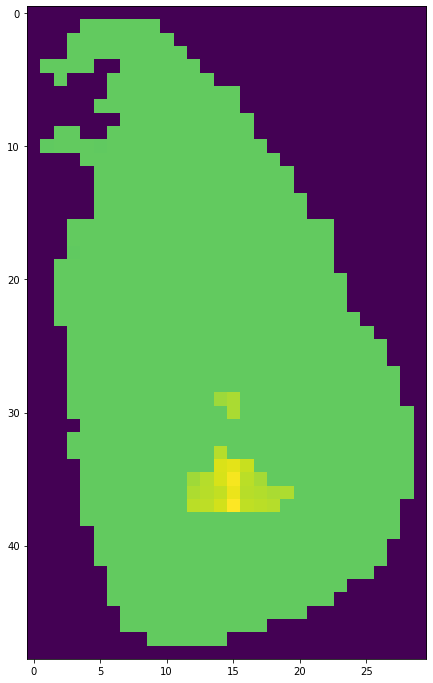

In [53]:
plt.figure(figsize = (12,12))
plt.imshow(data, cmap='viridis')
plt.show()

**Note!**

Rasterio imports raster files as 2-d arrays. The dimensions of the array are related to the spatial resolution of the imported layer. Individual values can be access in common practice as in numpy arrays. 

### Import tif and transform it to point vector

In [54]:
# Define functions

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]+(geotransform[1]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    originY = geotransform[3]+(geotransform[5]/2)     # this is to get the center of each pixel; remove all after + for getting the corners of the pixel
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn, band_no):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(band_no)    # Be aware of the band you need here
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTString))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
        if ridx % 10 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            index = str(ridx) + "_" + str(cidx)
            Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
            point.AddPoint(Xcoord, Ycoord)
            # Create the feature and set values
            outFeature = ogr.Feature(featureDefn)
            outFeature.SetGeometry(point)
            outFeature.SetField("VALUE", str(index))
            outLayer.CreateFeature(outFeature)
            outFeature.Destroy()
            #outDS.Destroy()
    print ("\nProcess completed!")

def main(rasterfn,outSHPfn, band_no):
    array = raster2array(rasterfn, band_no)
    array2shp(array,outSHPfn,rasterfn)

In [55]:
# Provide the input raster and give a name to the output transformed vector
raster = out_path + "\\" + raster_nm
outSHP = out_path + "\\" + shp_nm

# Run the function
main(raster,outSHP, band_no=3)

0 of 49 rows processed
10 of 49 rows processed
20 of 49 rows processed
30 of 49 rows processed
40 of 49 rows processed

Process completed!


### Import vector point layer into a geo-dataframe

In [56]:
# Create a new geo-dataframe
data_gdf = gpd.read_file(out_path + "\\" + shp_nm)

# Assign crs
data_gdf.crs = crs_WGS84

In [57]:
data_gdf.head(3)

,VALUE,geometry
0,0_0,POINT (79.54167 9.87500)
1,0_1,POINT (79.62500 9.87500)
2,0_2,POINT (79.70833 9.87500)


**Note!**

VALUE has been retrieved from the ascii file; it denotes the number of row and column in the initial layer, split by the underscore delimiter. We may use the following function to a) split them into two different columns and b) create a tuple from their combination (this is needed in case we follow the CLEWs clustering approach). 

In [58]:
def create_rowcol_columns(df):
    
    # Split the Value to rows and columns
    split = df["VALUE"].str.split("_", n = 1, expand = True)
    
    # Drop the VALUE as it has served its purpose
    df = df.drop(["VALUE"], axis=1)
    
    # Add the separate columns back to the dataframe
    df["row"] = split[0]
    df["col"] = split[1]
    
    # Change dtype of columns from str to int
    df["row"] = df["row"].astype(np.int)
    df["col"] = df["col"].astype(np.int)
    
    # Create a tuple id to use for merging later on
    df["id"] = list(zip(df.row, df.col)) 
    
    return df

In [59]:
data_gdf = create_rowcol_columns(data_gdf)

In [60]:
data_gdf.head(3)

,geometry,row,col,id
0,POINT (79.54167 9.87500),0,0,"(0, 0)"
1,POINT (79.62500 9.87500),0,1,"(0, 1)"
2,POINT (79.70833 9.87500),0,2,"(0, 2)"


## Step 2. Assign cluster name to points

In [61]:
def cleaning_string_attributes(df, column_name):
    df[column_name].replace("-", '_', regex=True, inplace=True)
    df[column_name].replace(" ", '_', regex=True, inplace=True)
    df[column_name].replace("/", '_', regex=True, inplace=True)
    df[column_name].replace("'", '_', regex=True, inplace=True)
    df[column_name].replace("é", 'e', regex=True, inplace=True)
    df[column_name].replace("î", 'i', regex=True, inplace=True)
    df[column_name].replace("ï", 'i', regex=True, inplace=True)
    df[column_name].replace("ô", 'o', regex=True, inplace=True)
    df[column_name].replace("è", 'e', regex=True, inplace=True)
    df[column_name].replace("à", 'a', regex=True, inplace=True)
    df[column_name].replace("", 'NaN', regex=True, inplace=True)
    df[column_name].fillna(value=np.nan, inplace=True)
    return df

**Note!**

The admin column names used in the code (e.g. "ADM1_NAME, or "NAME_0) might require changing depending on the source of those layers.

In [62]:
## Import admin layer accordingly

if clust_method == 1:
    
    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin1_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "ADM1_NAME")
    
    #Spatial join
    data_gdf_admin = gpd.sjoin(data_gdf, admin[["geometry", "ADM1_NAME"]], op='within').drop(['index_right'], axis=1)
    data_gdf_admin.rename(columns={'ADM1_NAME': 'cluster'}, inplace=True)
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(data_gdf_admin, on=["id"], how="left").drop(['id','row_y', 'col_y', "geometry_y"], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col', 'geometry_x': 'geometry'}, inplace=True)
    clustered_GAEZ_gdf = gpd.GeoDataFrame(clustered_GAEZ_gdf, geometry="geometry")
    
    
elif clust_method == 2:

    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin2_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "ADM2_NAME")
    
    #Spatial join
    data_gdf_admin = gpd.sjoin(data_gdf, admin[["geometry", "ADM2_NAME"]], op='within').drop(['index_right'], axis=1)
    data_gdf_admin.rename(columns={'ADM2_NAME': 'cluster'}, inplace=True)
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(data_gdf_admin, on=["id"], how="left").drop(['id','row_y', 'col_y', "geometry_y"], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col', 'geometry_x': 'geometry'}, inplace=True)
    clustered_GAEZ_gdf = gpd.GeoDataFrame(clustered_GAEZ_gdf, geometry="geometry")
    
    
elif clust_method == 3:
    ##  Read admin layer as geodataframe
    admin = gpd.read_file(in_path + "\\" + admin0_nm)
    admin = admin.to_crs(crs_WGS84)
    admin = cleaning_string_attributes(admin, "NAME_0")
    
    # Import csv as pandas dataframe
    cluster_data = pd.read_csv(in_path + "\\" + clust_nm)
    # Create a tuple id to be used for merging
    cluster_data['id'] = list(zip(cluster_data.row, cluster_data.col))
    # merge datasets on id
    clustered_GAEZ_gdf = data_gdf.merge(cluster_data, on=["id"], how="left").drop(['id','row_y', 'col_y'], axis=1)
    clustered_GAEZ_gdf.rename(columns={'row_x': 'row', 'col_x': 'col'}, inplace=True)
    
else:
    print ("Please specify clustering method to proceed")

In [63]:
clustered_GAEZ_gdf.sample(3)

,geometry,row,col,cluster
144,POINT (81.54167 9.54167),4,24,NaN
854,POINT (80.70833 7.54167),28,14,Central
194,POINT (80.70833 9.37500),6,14,Northern


At this point each vector point represents a particular location on the map -it has certain coordinates- and is categorized into a cluster based on the users selection.

## Step 3. Converting points to polygons
This allows further flexibility in the extraction of raster values using stats. In any case we have the lat,lon coordinates of each point so it is easy to revert to the point geometry. Here, we create a rectangular, buffer-based polygon around each point. 

The buffered polygon shall split "equally" the area between neighbor points; therefore, the buffer used shall be the half of the distance between two neighbor points. This, in turn depends on the location of the AoI on earth and the projection system used. 

We suggest two approaches described below.

### Assigning CRS | projecting | adding lat, lon coordinates in degrees

In [64]:
clustered_GAEZ_gdf.crs = crs_WGS84

In [65]:
clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y

<ipython-input-65-c1a650f5b317>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lon"] = clustered_GAEZ_gdf.geometry.centroid.x
<ipython-input-65-c1a650f5b317>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf["lat"] = clustered_GAEZ_gdf.geometry.centroid.y


In [66]:
clustered_GAEZ_gdf.head(2)

,geometry,row,col,cluster,lon,lat
0,POINT (79.54167 9.87500),0,0,NaN,79.541667,9.875
1,POINT (79.62500 9.87500),0,1,NaN,79.625000,9.875


### Estimating buffer radious

**Approach 1** (suggested)

Here, we estimate the buffer by calculating the haversine distance between two neighbor points; we use the median value of lat. 

In [67]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [68]:
# We select a randon set of neighbors; the gdf should be sorted thus here using the median index
index_1 = clustered_GAEZ_gdf[clustered_GAEZ_gdf.lat == clustered_GAEZ_gdf.lat.median()].index.tolist()[1]
index_2 = int(index_1 + 1)

# Note! We multiply by 1000 for meters and devide by 2 as we want half of the distance between the two points
clustered_GAEZ_gdf['buf_val_1'] = round(haversine(clustered_GAEZ_gdf["lon"][index_1],
                                                  clustered_GAEZ_gdf["lat"][index_1],
                                                  clustered_GAEZ_gdf["lon"][index_2],
                                                  clustered_GAEZ_gdf["lat"][index_2])*1000/2)

**Approach 2**

Here we use an empirical formula to estimate the "latmeters". That is, we estimate the equivalent value of a degree magnitude in meters based on the latitude of a location. Therefore, each point in the dataframe is assigned a slightly different buffer.

In [69]:
def find_buffer_from_lat(lat, res=resolution):
    """
    Calculate meters per latitude value 
    INPUT 
    lat: latitude in degrees
    res: resolution of original raster layer
    OUTPUT
    latlen: Estimated value of buffer for polygon creation in meters
    """ 
    latlen = (111132.954 - 559.822 * cos(2*lat) + 1.175 * cos(4*lat))*res/2
    return latlen
# Emperical formula retrieved from https://gis.stackexchange.com/questions/75528/understanding-terms-in-length-of-degree-formula

In [70]:
## Un-comment to run
#clustered_GAEZ_gdf['buf_val_2'] =clustered_GAEZ_gdf['lat'].apply(find_buffer_from_lat)

### Create polygons based on identified buffer

#### Project dataframe to the proper coordinate system

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the "EPSG" part)**.

**NOTE** When selecting your coordinate system make sure that you select a system with the unit of meters, this is indicated for all systems on [epsg.io](http://epsg.io/)

In [71]:
clustered_GAEZ_gdf_prj = clustered_GAEZ_gdf.to_crs(crs_proj)

#### ... and create the polygons 

Note! You can replace *'buf_val_1'* to *'buf_val_2'* if you find the second approach fit for purpose.

In [72]:
## cap_style refers to the type of geometry generated; 3=rectangular (see shapely documectation for more info -- https://shapely.readthedocs.io/en/stable/manual.html)
clustered_GAEZ_gdf_prj['geometry'] = clustered_GAEZ_gdf_prj.apply(lambda x:
                                                                  x.geometry.buffer(x.buf_val_1, cap_style=3), axis=1)

**... and revert the dataframe to the original CRS**

In [73]:
clustered_GAEZ_gdf = clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

**Note!** Several features are not classified into a cluster. While points away of the administrative borders will be cut out of the analysis, some points right next to the outer administrative borders might create inconsistency when calculating area. In the following section we are dealing with this problem.

## Step 4. Fixing missing values

### Adding an index column
(for easier identification/selection later on)

In [74]:
clustered_GAEZ_gdf['index'] = range(1, len(data_gdf)+1)

### Reduce running types | reassure expected output

**Note** 

The following part may lead to varying running times. In favor of reducing running times, we may clip of the vector polygons to the country extent using **national administrative boundaries** 

Clipping will not create any problems to landlocked countries (e.g. Ethiopia) as their borders are mostly covered by land. Therefore recommended in such cases.

However, for coastal or island countries (e.g. Sri Lanka) the algorithm may miss border clusters with very little land cover (e.g. few disperse, small islands). In order to prevent this from happening, we run the nearest neighbor algorithm over the whole extent of the gridded country and clip to the country extent at the end.

You may run either of the versions as you see necessary; here we use the *"landlocked"* variable to make a simple distinction between the two. 

In [75]:
# Clip based on topology of the selected country
if landlocked == 1:
    clustered_GAEZ_gdf = gpd.clip(clustered_GAEZ_gdf, admin)
else:
    clustered_GAEZ_gdf = clustered_GAEZ_gdf

### Split vector points based on cluster assignment 

In [76]:
# Change type of cluster column to string for next step's selection
clustered_GAEZ_gdf.cluster = clustered_GAEZ_gdf.cluster.astype(str)

Points within admin boundaries that are assigned to a cluster

In [77]:
clustered_GAEZ_gdf_non_nan = clustered_GAEZ_gdf[clustered_GAEZ_gdf["cluster"] != "nan"]
clustered_GAEZ_gdf_non_nan.geometry = clustered_GAEZ_gdf_non_nan.geometry.centroid
clustered_GAEZ_gdf_non_nan.head(3)

<ipython-input-77-ddada813bf57>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_non_nan.geometry = clustered_GAEZ_gdf_non_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
35,POINT (79.95833 9.79167),1,5,Northern,79.958333,9.791667,4589,36
36,POINT (80.04167 9.79167),1,6,Northern,80.041667,9.791667,4589,37
37,POINT (80.12500 9.79167),1,7,Northern,80.125000,9.791667,4589,38


Points within admin boundaries but not assigned to a cluster

In [78]:
clustered_GAEZ_gdf_nan = clustered_GAEZ_gdf[clustered_GAEZ_gdf["cluster"] == "nan"]
clustered_GAEZ_gdf_nan.geometry = clustered_GAEZ_gdf_nan.geometry.centroid
clustered_GAEZ_gdf_nan.head(3)

<ipython-input-78-465c0ec06b28>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  clustered_GAEZ_gdf_nan.geometry = clustered_GAEZ_gdf_nan.geometry.centroid
C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,geometry,row,col,cluster,lon,lat,buf_val_1,index
0,POINT (79.54167 9.87500),0,0,nan,79.541667,9.875,4589,1
1,POINT (79.62500 9.87500),0,1,nan,79.625000,9.875,4589,2
2,POINT (79.70833 9.87500),0,2,nan,79.708333,9.875,4589,3


### Get nearest neighbor for points not assigned

In [79]:
# Simple function getting the nearest hub for a given set of points
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [80]:
# Apply fuction to the non cluster points dataframe
clustered_GAEZ_gdf_nan["index_nn"] = clustered_GAEZ_gdf_nan.apply(calculate_nearest,
                                                                               destination=clustered_GAEZ_gdf_non_nan,
                                                                               val="index",
                                                                               axis=1)

C:\Users\alexl\anaconda3\envs\clews_gis_work\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


The dataframe has now been attributed with the index of the nearest neighbor 

In [81]:
clustered_GAEZ_gdf_nan.head(3)

,geometry,row,col,cluster,lon,lat,buf_val_1,index,index_nn
0,POINT (79.54167 9.87500),0,0,nan,79.541667,9.875,4589,1,65
1,POINT (79.62500 9.87500),0,1,nan,79.625000,9.875,4589,2,65
2,POINT (79.70833 9.87500),0,2,nan,79.708333,9.875,4589,3,65


### Merge the two split dataframe 

This action works similar to the VLOOKUP fuction in excel. For each index_nn in the first dataframe looks at the index of the second dataframe and assigns attributes to the primer as per need. In this case, we assign the cluster name of the nearest neighbor.

In [82]:
clustered_GAEZ_gdf_nan_n = clustered_GAEZ_gdf_nan.merge(clustered_GAEZ_gdf_non_nan[['index','cluster']],
                                                                      how = "left",
                                                                      left_on = "index_nn",
                                                                      right_on='index').drop(["index_nn", "cluster_x","index_x"], axis=1)

In [83]:
clustered_GAEZ_gdf_nan_n.rename(columns={'index_y': 'index', 'cluster_y': 'cluster'}, inplace=True)

### Concatenate the two split dataframes into a single one
(updating the original clipped dataframe)

In [84]:
clustered_GAEZ_gdf_new = clustered_GAEZ_gdf_non_nan.append(clustered_GAEZ_gdf_nan_n)

In [85]:
clustered_GAEZ_gdf_new.head(2)

,geometry,row,col,cluster,lon,lat,buf_val_1,index
35,POINT (79.95833 9.79167),1,5,Northern,79.958333,9.791667,4589,36
36,POINT (80.04167 9.79167),1,6,Northern,80.041667,9.791667,4589,37


### And finally, merge back to the clipped polygon layer using spatial join
(this is to re-gain the polygon geometry)

In [86]:
#Spatial join
final_clustered_GAEZ_gdf = gpd.sjoin(clustered_GAEZ_gdf_new, clustered_GAEZ_gdf[["geometry"]], op='within', how='right')

### Clip results in case of coastal or island countries

In [87]:
if landlocked == 1:
    final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf
else:
    final_clustered_GAEZ_gdf = gpd.clip(final_clustered_GAEZ_gdf, admin)

## Step 5. Total area re-estimation & calibration

This step estimates and calibrates the area (in square km) based on the area provided by the admin layer used in the analysis (e.g. clipping). 

In [88]:
# project datasets to proper crs
final_clustered_GAEZ_gdf_prj = final_clustered_GAEZ_gdf.to_crs(crs_proj)
admin_proj = admin.to_crs(crs_proj)

In [89]:
final_clustered_GAEZ_gdf_prj["sqkm"] = final_clustered_GAEZ_gdf_prj['geometry'].area/10**6

In [90]:
def get_multiplier(estimated, official):
    if official == estimated:
        return 1
    try:
        return  official / estimated
    except ZeroDivisionError:
        return 0

In [91]:
estimated_area = final_clustered_GAEZ_gdf_prj.sqkm.sum()
official_area = admin_proj.geometry.area.sum()/10**6

# Estimate column multipler
multiplier = get_multiplier(estimated_area, official_area)

In [92]:
final_clustered_GAEZ_gdf_prj.sqkm = final_clustered_GAEZ_gdf_prj.sqkm * multiplier

In [93]:
print ("Our modelling exercise yields a total area of {0:.1f} sqkm for the country".format(estimated_area))
print ("The admin layer indicates {0:.1f} sqkm".format(official_area))
print ("After calibration the total area is set at {0:.1f} sqkm".format(final_clustered_GAEZ_gdf_prj.sqkm.sum()))

Our modelling exercise yields a total area of 65783.7 sqkm for the country
The admin layer indicates 66126.9 sqkm
After calibration the total area is set at 66126.9 sqkm


## Final check and Export

#### Revert to original CRS

In [94]:
final_clustered_GAEZ_gdf = final_clustered_GAEZ_gdf_prj.to_crs(crs_WGS84)

#### Make a final check before exporting

In [95]:
final_clustered_GAEZ_gdf.head(2)

,index_left,row,col,cluster,lon,lat,buf_val_1,index,geometry,sqkm
8,8,0,8,Northern,80.208333,9.875000,4589,39,"POLYGON ((80.21857 9.83352, 80.20567 9.83349, ...",0.161502
34,34,1,4,Northern,79.875000,9.791667,4589,36,"MULTIPOLYGON (((79.91689 9.77569, 79.91697 9.7...",8.078459


#### Finally export the output layer

In [96]:
# Export as shapefile 
if clust_method == 1:
    final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=out_nm_1)), driver="GPKG")
elif clust_method == 2:
    final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=out_nm_2)), driver="GPKG")
else:
    final_clustered_GAEZ_gdf.to_file(os.path.join(out_path,"{c}.gpkg".format(c=out_nm_3)), driver="GPKG")
    
print ("Process complete!", "\U0001F60E")

Process complete! 😎
